In [1]:
import sys
sys.path.append('../')

from costing import costing
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
pd.set_option("display.precision", 5)
pd.set_option('display.max_columns', None)

plt.style.use('ggplot')

### Load data

In [4]:
# csv ending in _old is the original data
# others are extracted using the concurrent script

requests_old = pd.read_csv("./data/requests_old.csv")
delivers_old = pd.read_csv("./data/delivers_old.csv")
tools_old = pd.read_csv("./data/tools_old.csv")

requests = pd.read_parquet("./data/requests.parquet")
delivers = pd.read_parquet("./data/delivers.parquet")
tools = pd.read_parquet("./data/tools.parquet")


### Error calls

In [5]:
delivers_old_request_id = delivers_old.request_id.unique()
requests_old['error'] = requests_old['request_id'].apply(lambda x: False if x in delivers_old_request_id else True)

In [6]:
err = requests_old.groupby(['tool', 'error']).count()['request_id'].unstack().sort_values(by=False, ascending=False)
err['perc_error'] = (err[True]/(err[True]+err[False]))*100
err

error,False,True,perc_error
tool,,,
prediction-online,13672.0,13115.0,48.96032
prediction-online-sme,6835.0,2876.0,29.61590
prediction-offline-sme,1225.0,1364.0,52.68443
prediction-offline,1106.0,1182.0,51.66084
claude-prediction-offline,938.0,2315.0,71.16508
claude-prediction-online,691.0,3034.0,81.44966
prediction-online-summarized-info,82.0,169.0,67.33068
prediction-sentence-embedding-bold,6.0,85.0,93.40659
prediction-sentence-embedding-conservative,2.0,36.0,94.73684


In the above we are checking whether all of the request calls have corresponding deliver reponses. From our study, this happens because of `Invalid Response` by the tool or the result from the tool cannot be parsed.


The above result shows some of the tools have a large `error` rate.

### Costing

<AxesSubplot:>

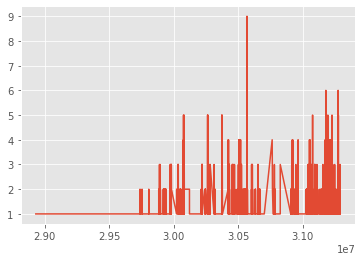

In [7]:
tools_old['deliver_block'].value_counts().sort_index().plot()

<AxesSubplot:>

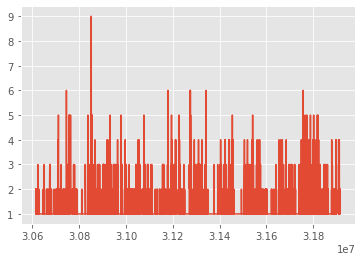

In [8]:
tools['deliver_block'].value_counts().sort_index().plot()

There is less data on new `tools` because `old_mech` didnt save the full prompt

In [9]:
# add full_prompt to dataset
include_tools = [
    'prediction-offline',
    'prediction-online',
    'prediction-online-summarized-info',
    'prediction-offline-sme',
    'prediction-online-sme',
    'claude-prediction-online',
    'claude-prediction-offline'
]

tools = tools[tools.tool.isin(include_tools)]

Below we calculate the number of words in the request prompts and response prompts. 

<AxesSubplot:>

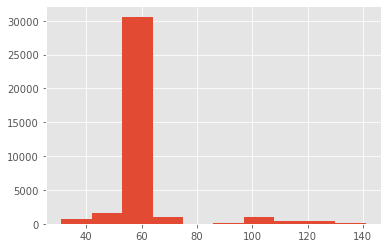

In [10]:
# prompt_request is the from the prompt from trader to mech (tool)
tools['prompt_request'].apply(lambda x: len(x.split(' '))).hist()

<AxesSubplot:>

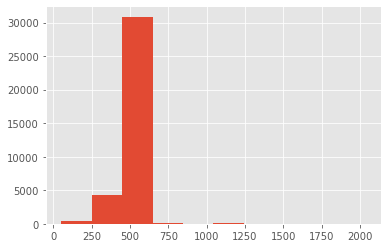

In [11]:
# prompt_response is the full prompt used by the mech (tool)
tools['prompt_response'].apply(lambda x: len(x.split(' '))).hist()

Below, we calculate the number of tokens in the request prompts and response prompts.  

<AxesSubplot:>

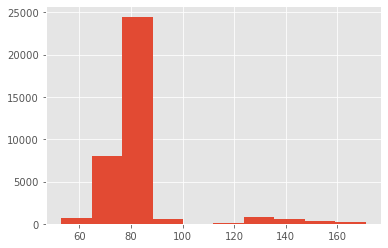

In [12]:
tools['prompt_request_token'] = tools['prompt_request'].apply(lambda x: costing.TokenCounter.count_tokens(x, model='gpt-3.5-turbo'))
tools['prompt_request'].apply(lambda x: costing.TokenCounter.count_tokens(x, model='gpt-3.5-turbo')).hist()

<AxesSubplot:>

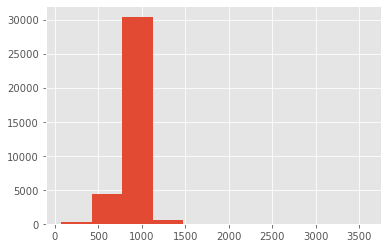

In [13]:
tools['prompt_response_token'] = tools['prompt_response'].apply(lambda x: costing.TokenCounter.count_tokens(x, model='gpt-3.5-turbo'))
tools['prompt_response'].apply(lambda x: costing.TokenCounter.count_tokens(x, model='gpt-3.5-turbo')).hist()

Below, we show the number of response prompt tokens used for each tool. 

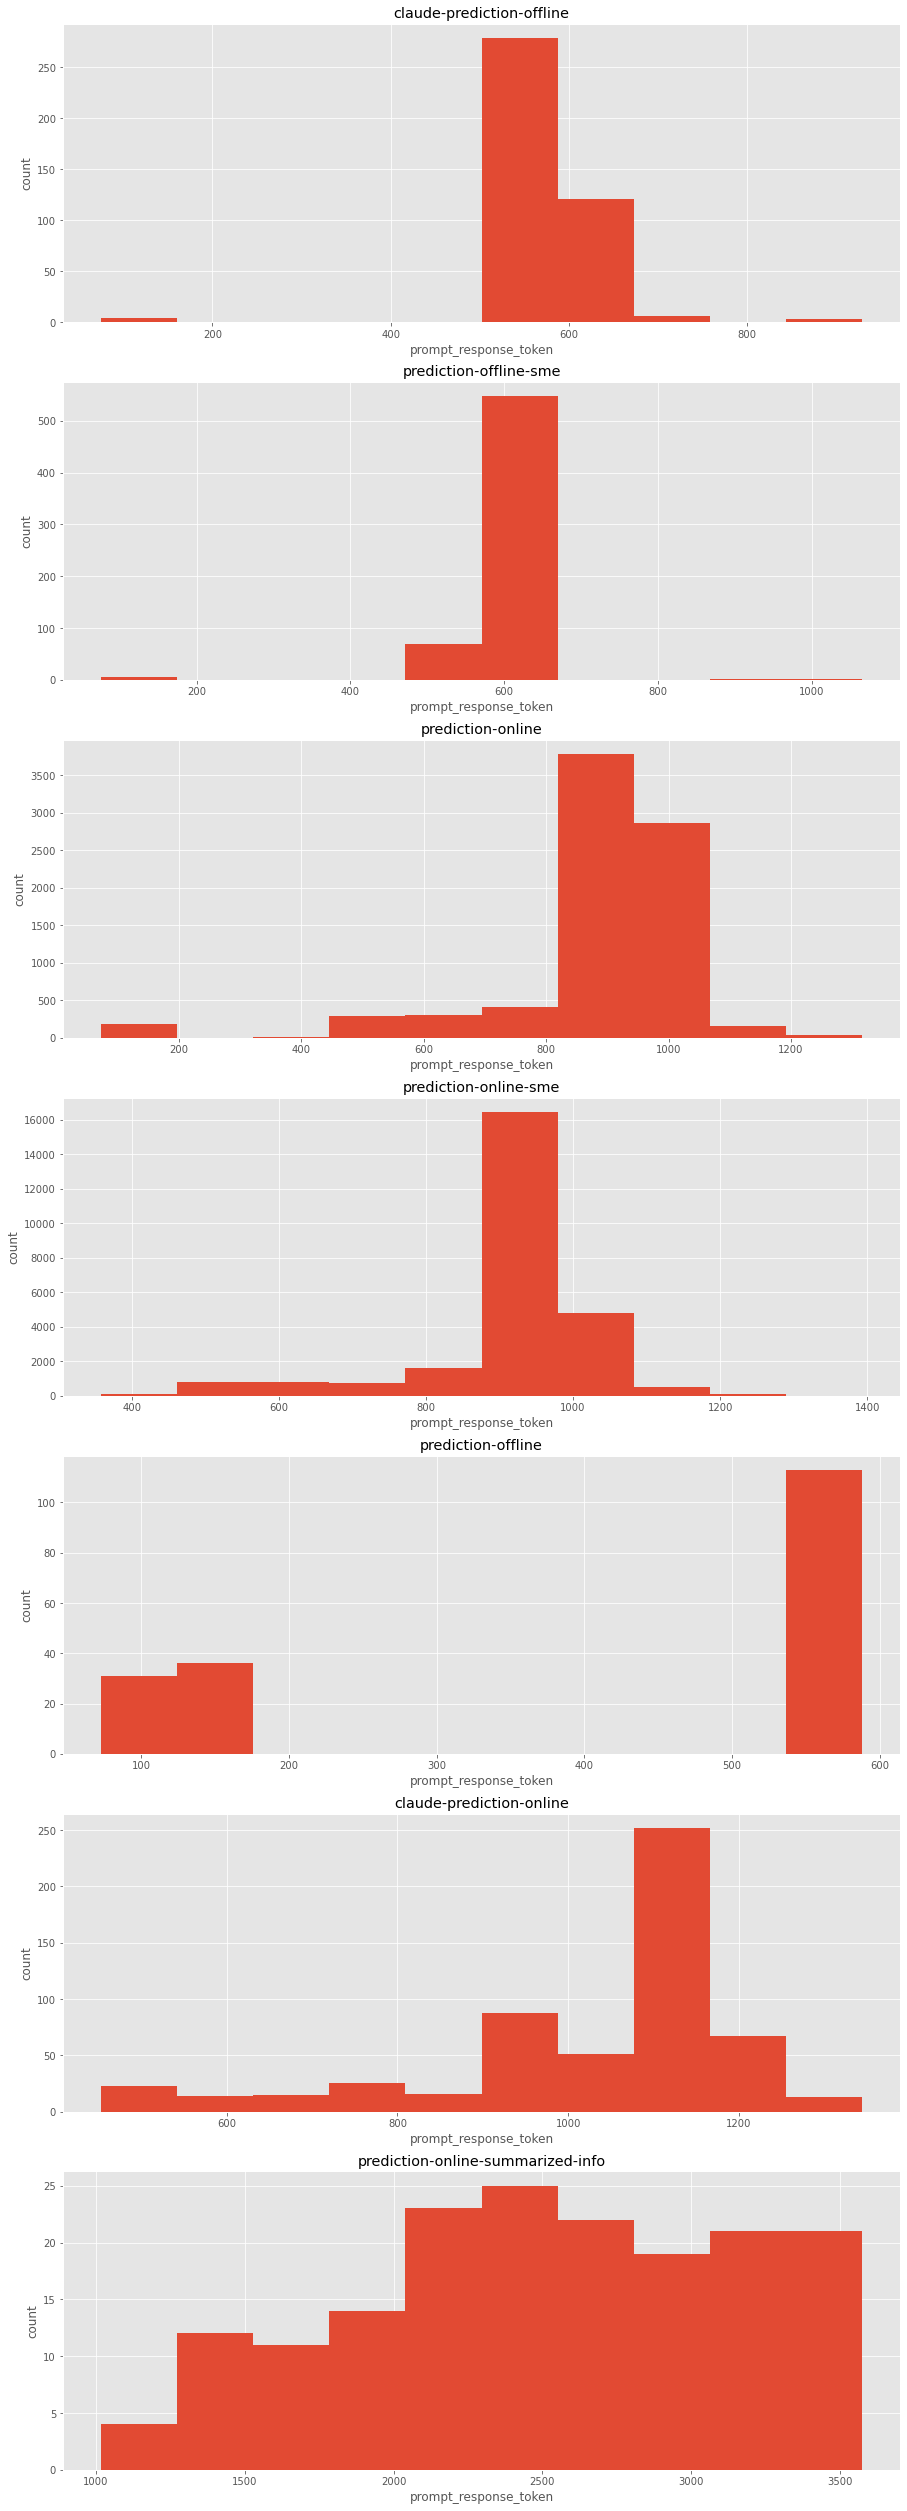

In [14]:
fig, axes = plt.subplots(7, 1, figsize=(15, 45))

for i, tool in enumerate(tools['tool'].unique()):
    tools[tools['tool'] == tool]['prompt_response_token'].hist(ax=axes[i])
    axes[i].set_title(tool)
    axes[i].set_xlabel('prompt_response_token')
    axes[i].set_ylabel('count')

Below is the mean prompt response tokens for each tool, sorted by most tokens. 

In [15]:
tools.groupby('tool')['prompt_response_token'].mean().sort_values(ascending=False)

tool
prediction-online-summarized-info    2501.93023
claude-prediction-online             1025.07257
prediction-online-sme                 916.45204
prediction-online                     887.51860
claude-prediction-offline             591.58838
prediction-offline-sme                586.10224
prediction-offline                    398.88333
Name: prompt_response_token, dtype: float64

In [16]:
for data in tqdm(tools.iterrows(), total=len(tools), desc='Counting costs'):
    tool = data[1].tool
    prompt = data[1].prompt_response
    response = None
    counter = costing.CostCounter(tool=tool, prediciton_prompt=prompt, final_response=response)
    cost = counter.run()
    tools.loc[data[0], 'cost'] = cost
    tools.loc[data[0], 'input_tokens'] = counter.total_input_tokens
    tools.loc[data[0], 'output_tokens'] = counter.total_output_tokens

Counting costs: 100%|██████████| 35869/35869 [03:30<00:00, 170.42it/s]


The below tables show more about the distribution about the overall cost for each tool.

In [17]:
tools.groupby('tool').cost.aggregate([
    'min', 'max', 'mean', 'median',
    lambda x: np.percentile(x, 75), 
    lambda x: np.percentile(x, 90)
]).rename(columns={
    '<lambda_0>': '75th percentile',
    '<lambda_1>': '90th percentile'
}).sort_values(by='90th percentile', ascending=False)

,min,max,mean,median,75th percentile,90th percentile
tool,,,,,,
claude-prediction-online,0.04032,0.05557,0.04982,0.05106,0.05178,0.05236
prediction-online-summarized-info,0.02775,0.03287,0.03072,0.03072,0.03183,0.03241
prediction-online-sme,0.02740,0.03051,0.02908,0.02914,0.02924,0.02937
prediction-online,0.02587,0.02835,0.02749,0.02758,0.02764,0.02772
claude-prediction-offline,0.00301,0.01030,0.00748,0.00740,0.00768,0.00774
prediction-offline-sme,0.00096,0.00294,0.00198,0.00196,0.00198,0.00209
prediction-offline,0.00027,0.00079,0.00060,0.00076,0.00077,0.00078


In [18]:
tools.groupby('tool').input_tokens.aggregate([
    'min', 'max', 'mean', 'median',
    lambda x: np.percentile(x, 75), 
    lambda x: np.percentile(x, 90)
]).rename(columns={
    '<lambda_0>': '75th percentile',
    '<lambda_1>': '90th percentile'
}).sort_values(by='90th percentile', ascending=False)

,min,max,mean,median,75th percentile,90th percentile
tool,,,,,,
prediction-online-summarized-info,2353.0,7467.0,5322.86047,5324.0,6433.5,7006.6
prediction-online-sme,1802.0,4907.0,3477.35613,3539.0,3638.0,3767.0
claude-prediction-online,1315.0,3221.0,2502.13805,2657.0,2747.0,2820.2
prediction-online,466.0,2951.0,2094.06025,2177.0,2241.0,2323.0
prediction-offline-sme,562.0,2539.0,1581.21406,1563.0,1583.0,1689.0
claude-prediction-offline,76.0,987.0,634.63196,625.0,660.0,667.0
prediction-offline,73.0,588.0,398.88333,558.0,573.0,577.0


In [19]:
tools.groupby('tool').output_tokens.aggregate([
    'min', 'max', 'mean', 'median',
    lambda x: np.percentile(x, 75), 
    lambda x: np.percentile(x, 90)
]).rename(columns={
    '<lambda_0>': '75th percentile',
    '<lambda_1>': '90th percentile'
}).sort_values(by='90th percentile', ascending=False)

,min,max,mean,median,75th percentile,90th percentile
tool,,,,,,
prediction-online-sme,300.0,300.0,300.0,300.0,300.0,300.0
claude-prediction-online,200.0,200.0,200.0,200.0,200.0,200.0
prediction-offline-sme,200.0,200.0,200.0,200.0,200.0,200.0
prediction-online,200.0,200.0,200.0,200.0,200.0,200.0
prediction-online-summarized-info,200.0,200.0,200.0,200.0,200.0,200.0
claude-prediction-offline,100.0,100.0,100.0,100.0,100.0,100.0
prediction-offline,100.0,100.0,100.0,100.0,100.0,100.0
